In [2]:
import time

from PIL import Image
import numpy as np
import skimage
from scipy.ndimage.morphology import distance_transform_edt
import matplotlib.pyplot as plt
import tensorflow as tf

input_size = 128
output_size = 192
expand_size = (output_size - input_size) // 2
patch_w = output_size // 8
patch_h = output_size // 8
patch = (1, patch_h, patch_w)

def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter

def resize_masking(input_img, size):
    resized = skimage.transform.resize(input_img, size, anti_aliasing=True)
    masked_img = np.ones((output_size, output_size, 3))
    masked_img[expand_size:-expand_size, expand_size:-expand_size, :] = resized
    assert(masked_img.shape[0] == output_size)
    assert(masked_img.shape[1] == output_size)
    assert(masked_img.shape[2] == 3)
    masked_img = masked_img.transpose(2, 0, 1)
    masked_img = tf.expand_dims(masked_img, axis=0)
    return masked_img

def preprocess_image_for_int8(input_img, quantization_params=None, to_int=False):
    input_img = input_img / quantization_params['scale'] + quantization_params['zero_point']
    input_img = np.round(input_img).astype(np.int8)
    return input_img

def predict_image(interpreter, input_img):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_img = np.array(input_img, dtype=np.float32) if input_details[0]['dtype'] == np.float32 else np.array(input_img, dtype=np.int8)
    interpreter.set_tensor(input_details[0]['index'], input_img)
    interpreter.invoke()
    output_img = interpreter.get_tensor(output_details[0]['index'])
    return output_img

def postprocess_image(image, quantization_params=None, to_int=False):
    image = image.squeeze().transpose(1, 2, 0)
    if to_int:
        image = (image - quantization_params['zero_point']) * quantization_params['scale']
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = image.squeeze().transpose(1, 2, 0)
        image = np.clip(image * 255, 0, 255)
        image = image.astype(np.uint8)
    else:
        image = np.clip(image, 0, 1)
        image = (image * 255).astype(np.uint8) 
    return image

def blend(output_img, input_img, blend_width=8):
    in_factor = input_size / output_size
    if input_img.shape[1] < in_factor * output_img.shape[1]:
        # Output dominates, adapt input
        out_width, out_height = output_img.shape[1], output_img.shape[0]
        in_width, in_height = int(out_width * in_factor), int(out_height * in_factor)
        input_img = skimage.transform.resize(input_img, (in_height, in_width), anti_aliasing=True)
    else:
        # Input dominates, adapt output
        in_width, in_height = input_img.shape[1], input_img.shape[0]
        out_width, out_height = int(in_width / in_factor), int(in_height / in_factor)
        output_img = skimage.transform.resize(output_img, (out_height, out_width), anti_aliasing=True)
    
    # Construct source mask
    src_mask = np.zeros((output_size, output_size))
    src_mask[expand_size+1:-expand_size-1, expand_size+1:-expand_size-1] = 1 # 1 extra pixel for safety
    src_mask = distance_transform_edt(src_mask) / blend_width
    src_mask = np.minimum(src_mask, 1)
    src_mask = skimage.transform.resize(src_mask, (out_height, out_width), anti_aliasing=True)
    src_mask = np.tile(src_mask[:, :, np.newaxis], (1, 1, 3))
    
    # Pad input
    input_pad = np.zeros((out_height, out_width, 3))
    x1 = (out_width - in_width) // 2
    y1 = (out_height - in_height) // 2
    input_pad[y1:y1+in_height, x1:x1+in_width, :] = input_img
    
    # Merge
    blended = input_pad * src_mask + output_img * (1 - src_mask)

    return blended, src_mask

def outpaint(output_img, input_img):
    norm_input_img = input_img.copy().astype('float')
    if np.max(norm_input_img) > 1: norm_input_img /= 255
    blended_img, _ = blend(output_img, norm_input_img)
    blended_img = np.clip(blended_img, 0, 1)

    return output_img, blended_img

/tmp/ipykernel_2160668/1530162909.py:6: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt
2024-05-31 09:26:30.214331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 09:26:30.214379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 09:26:30.215375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 09:26:30.222022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimize

In [8]:
image_name = 'sample'

for i in ['art','nat','rec']:
    for j in ['fp32','fp16','int8']:

        model_path = f'models/G_{i}_{j}.tflite'
        image_path = f'{image_name}.jpeg'
        input_img = plt.imread(image_path)[:, :, :3]
        output_image_path = f'{image_name}/{i}_{j}_blend.jpg'
        interpreter = load_tflite_model(model_path)
        
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        input_shape = input_details[0]['shape']
        input_quant_params = input_details[0]['quantization']
        output_quant_params = output_details[0]['quantization']
        masked_img = resize_masking(input_img, (input_size, input_size))
        
        if j == 'int8':
            quantization_params = {
                'scale': input_quant_params[0],
                'zero_point': input_quant_params[1]
            }    
            output_quantization_params = {
                'scale': output_quant_params[0],
                'zero_point': output_quant_params[1]
            }       
            input_image = preprocess_image_for_int8(masked_img, quantization_params, True)
            output_img = predict_image(interpreter, input_image)
            output_img = postprocess_image(output_img, output_quantization_params, True)
        else:
            output_img = predict_image(interpreter, masked_img)
            output_img = postprocess_image(output_img)
        
        output_img, blended_img = outpaint(output_img, input_img)
        blended_scaled = (blended_img * 255).astype('uint8')
        
        blended_img = Image.fromarray(blended_scaled)
        blended_img_path = f'{image_name}/{i}_{j}_blend.jpg'
        blended_img.save(blended_img_path)

        output_img = Image.fromarray(output_img)
        output_img_path = f'{image_name}/{i}_{j}_output.jpg'
        output_img.save(output_img_path)

[[[218 198 204]
  [228 212 218]
  [222 208 214]
  ...
  [237 236 238]
  [234 233 235]
  [219 218 226]]

 [[216 200 209]
  [220 206 214]
  [216 202 210]
  ...
  [239 239 241]
  [235 236 238]
  [237 236 238]]

 [[213 202 209]
  [212 200 210]
  [206 196 205]
  ...
  [241 241 243]
  [239 240 241]
  [237 237 238]]

 ...

 [[ 94 118  56]
  [ 56  82  13]
  [ 91 118  37]
  ...
  [ 77  89  44]
  [ 80  92  44]
  [ 86  93  53]]

 [[ 84 112  51]
  [ 48  70  12]
  [ 70  93  14]
  ...
  [ 81  89  48]
  [ 86  97  53]
  [ 92 105  57]]

 [[103 127  71]
  [100 126  53]
  [123 146  67]
  ...
  [ 78  90  43]
  [ 81  91  48]
  [ 88  98  54]]]


In [26]:
import kagglehub

# Download latest version
path = kagglehub.model_download("kaggle/esrgan-tf2/tfLite/esrgan-tf2")

print("Path to model files:", path)

Path to model files: /home/compu/.cache/kagglehub/models/kaggle/esrgan-tf2/tfLite/esrgan-tf2/1


Path to model files: /home/compu/.cache/kagglehub/models/kaggle/esrgan-tf2/tfLite/esrgan-tf2/1


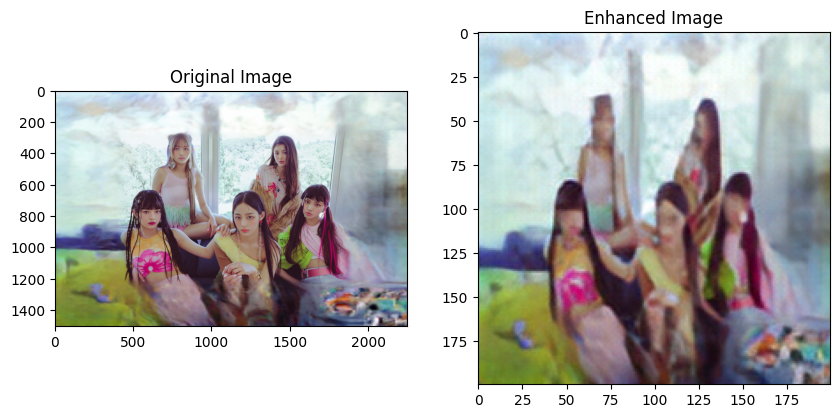

In [15]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import kagglehub
import matplotlib.pyplot as plt

# 모델 경로 설정 (kagglehub에서 다운로드한 경로)
model_path = kagglehub.model_download("kaggle/esrgan-tf2/tfLite/esrgan-tf2")
print("Path to model files:", path)
model_file_path = os.path.join(model_path, "1.tflite")

# 모델 로드
interpreter = tf.lite.Interpreter(model_path=model_file_path)
interpreter.allocate_tensors()

# 입력 및 출력 텐서 정보 가져오기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 이미지 전처리 함수
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))
    img = np.array(img).astype('float32')
    img = np.expand_dims(img, axis=0)  # 배치를 위해 차원 확장
    return img

# 이미지 후처리 함수
def postprocess_image(output_data):
    output_data = output_data.squeeze()  # 배치 차원 제거
    output_data = np.clip(output_data, 0, 255).astype('uint8')
    return Image.fromarray(output_data)

# 추론 함수
def enhance_image(image_path):
    input_data = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    enhanced_image = postprocess_image(output_data)
    return enhanced_image

input_image_path = "newjeans_sample_infer_blended_art.jpeg"
enhanced_image = enhance_image(input_image_path)

# 결과 이미지 표시
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(Image.open(input_image_path))
plt.subplot(1, 2, 2)
plt.title('Enhanced Image')
plt.imshow(enhanced_image)
plt.show()

# 결과 이미지 저장
enhanced_image.save("enhanced_image.jpg")


Path to model files: /home/compu/.cache/kagglehub/models/kaggle/esrgan-tf2/tfLite/esrgan-tf2/1


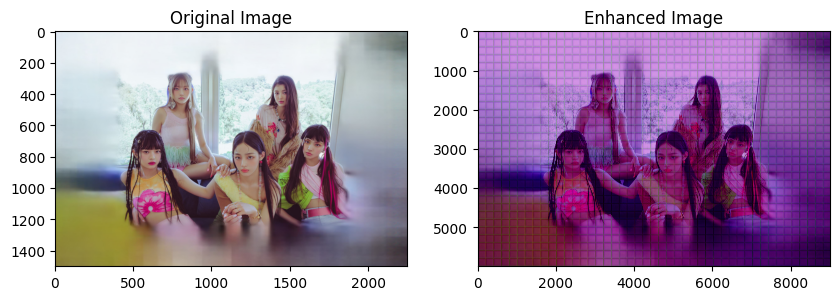

1033.6915185451508


In [6]:
import kagglehub
import time
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

st = time.time()
# 모델 경로 설정 (kagglehub에서 다운로드한 경로)
model_path = kagglehub.model_download("kaggle/esrgan-tf2/tfLite/esrgan-tf2")
print("Path to model files:", model_path)
model_file_path = os.path.join(model_path, "1.tflite")

# 모델 로드
interpreter = tf.lite.Interpreter(model_path=model_file_path)
interpreter.allocate_tensors()

# 입력 및 출력 텐서 정보 가져오기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 타일 크기 설정
input_tile_size = (50, 50)
output_tile_size = (200, 200)

# 이미지 전처리 함수
def preprocess_image(image, tile_size):
    img = np.array(image).astype('float32')
    img = img / 255.0  # 이미지 정규화
    return img

# 이미지 후처리 함수
def postprocess_image(output_data):
    output_data = np.clip(output_data * 255, 0, 255).astype('uint8')
    return output_data

# 이미지 타일로 나누기
def split_into_tiles(image, tile_size):
    tiles = []
    img_width, img_height = image.size
    for y in range(0, img_height, tile_size[1]):
        for x in range(0, img_width, tile_size[0]):
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))
            tiles.append((x, y, tile))
    return tiles

# 타일 결합하여 전체 이미지 복원
def combine_tiles(tiles, img_size, output_tile_size):
    img_width, img_height = img_size
    output_img = Image.new('RGB', (img_width * 4, img_height * 4))  # 확대된 이미지 크기
    for (x, y, tile) in tiles:
        output_img.paste(tile, (x * 4, y * 4))
    return output_img

# 추론 함수
def enhance_image(image_path):
    # 원본 이미지 열기
    original_image = Image.open(image_path).convert('RGB')
    
    # 이미지 타일로 나누기
    tiles = split_into_tiles(original_image, input_tile_size)
    
    enhanced_tiles = []
    for (x, y, tile) in tiles:
        input_data = preprocess_image(tile, input_tile_size)
        input_data = np.expand_dims(input_data, axis=0)  # 배치를 위해 차원 확장
        
        # 모델에 입력 데이터 설정
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # 추론 실행
        interpreter.invoke()
        
        # 출력 데이터 가져오기
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        # 후처리하여 타일 복원
        enhanced_tile = postprocess_image(output_data.squeeze())
        enhanced_tile_image = Image.fromarray(enhanced_tile)
        enhanced_tiles.append((x, y, enhanced_tile_image))
    
    # 향상된 타일 결합하여 전체 이미지 복원
    enhanced_image = combine_tiles(enhanced_tiles, original_image.size, output_tile_size)
    return enhanced_image

# 예시: 입력 이미지 경로
input_image_path = "newjeans_sample_infer_blended_rec.jpeg"

# 이미지 향상 수행
enhanced_image = enhance_image(input_image_path)

# 결과 이미지 표시
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(Image.open(input_image_path))
plt.subplot(1, 2, 2)
plt.title('Enhanced Image')
plt.imshow(enhanced_image)
plt.show()

# 결과 이미지 저장
enhanced_image.save("enhanced_image_newjeans.jpg")
print(time.time() - st)